In [1]:
# Start by importing packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame


In [2]:
# Set the data input directories:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
cooler_dir = os.path.join(current_dir, r'wrf_to_tell', r'data', r'rcp85cooler_ssp3')
hotter_dir = os.path.join(current_dir, r'wrf_to_tell', r'data', r'rcp85hotter_ssp3')
image_output_dir = os.path.join(current_dir, r'wrf_to_tell', r'images')


In [3]:
# Set the balancing authority to analyze:
ba_to_plot = 'CISO'


In [4]:
# Load in the raw data from the cooler scenario:
cooler_2081_df = pd.read_csv(os.path.join(cooler_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2081.csv'), index_col=None, header=0)
cooler_2082_df = pd.read_csv(os.path.join(cooler_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2082.csv'), index_col=None, header=0)
cooler_2083_df = pd.read_csv(os.path.join(cooler_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2083.csv'), index_col=None, header=0)

# Concatenate the three dataframes together:
cooler_df = pd.concat([cooler_2081_df, cooler_2082_df, cooler_2083_df])

# Rename the T2 variable:
cooler_df.rename(columns={'T2': 'T2_Cooler'}, inplace=True)

# Subset to only the columns we need:
cooler_df = cooler_df[['Time_UTC', 'T2_Cooler']]

# Load in the raw data from the hotter scenario:
hotter_2081_df = pd.read_csv(os.path.join(hotter_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2081.csv'), index_col=None, header=0)
hotter_2082_df = pd.read_csv(os.path.join(hotter_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2082.csv'), index_col=None, header=0)
hotter_2083_df = pd.read_csv(os.path.join(hotter_dir, f'{ba_to_plot}_WRF_Hourly_Mean_Meteorology_2083.csv'), index_col=None, header=0)

# Concatenate the three dataframes together:
hotter_df = pd.concat([hotter_2081_df, hotter_2082_df, hotter_2083_df])

# Rename the T2 variable:
hotter_df.rename(columns={'T2': 'T2_Hotter'}, inplace=True)

# Subset to only the columns we need:
hotter_df = hotter_df[['Time_UTC', 'T2_Hotter']]

# Merge the two dataframes together based on a common "Time_UTC" variable:
merged_df = pd.merge(cooler_df, hotter_df, how='left', on=['Time_UTC'])

# Calculate the temperature difference:
merged_df["T2_Difference"] = (merged_df['T2_Hotter'] - merged_df['T2_Cooler']).round(2)

# Convert the time to a datetime variable:
merged_df['Time_UTC'] = pd.to_datetime(merged_df['Time_UTC'])

# Clean up what we're not using anymore:
del cooler_df, cooler_2081_df, cooler_2082_df, cooler_2083_df, hotter_df, hotter_2081_df, hotter_2082_df, hotter_2083_df

# Return the merged dataframe:
merged_df


,Time_UTC,T2_Cooler,T2_Hotter,T2_Difference
0,2081-01-01 00:00:00,290.90,292.68,1.78
1,2081-01-01 01:00:00,287.85,289.58,1.73
2,2081-01-01 02:00:00,286.99,288.68,1.69
3,2081-01-01 03:00:00,286.60,288.27,1.67
4,2081-01-01 04:00:00,286.30,287.94,1.64
...,...,...,...,...
26107,2083-12-31 19:00:00,287.35,288.86,1.51
26108,2083-12-31 20:00:00,288.10,289.63,1.53
26109,2083-12-31 21:00:00,288.52,290.03,1.51
26110,2083-12-31 22:00:00,288.64,290.12,1.48


In [5]:
# Define a function to compute the monthly-mean time series of T2 values and differences:
def process_monthly_data(merged_df):
    
    # Initiate empty lists to store the monthly-mean results:
    years = []
    months = []
    mean_t2_cooler = []
    mean_t2_hotter = []
    mean_t2_difference = []
    
    # Loop over the years:
    for year in range(2081, 2084):
        # Loop over the months:
        for month in range(1, 13):
                       
            # Subset the data to the given year/month combination:
            month_subset_df = merged_df.loc[(merged_df['Time_UTC'].dt.strftime('%Y') == str(year)) & (merged_df['Time_UTC'].dt.strftime('%-m') == str(month))]
           
            # Store the output in a list:
            years.append(year)
            months.append(month)
            mean_t2_cooler.append(month_subset_df['T2_Cooler'].mean())
            mean_t2_hotter.append(month_subset_df['T2_Hotter'].mean())
            mean_t2_difference.append(month_subset_df['T2_Difference'].mean())
            
            del month_subset_df
    
    # Convert the output to a dataframe:
    mean_df = pd.DataFrame(mean_t2_cooler, columns = ['T2_Cooler_Mean'])
    mean_df['T2_Hotter_Mean'] = pd.DataFrame(mean_t2_hotter)
    mean_df['T2_Difference_Mean'] = pd.DataFrame(mean_t2_difference)
    mean_df['Month'] = months
    mean_df['Year'] = years
    mean_df['Time'] = mean_df['Year'] + (mean_df['Month'] / 12)
    
    mean_df = mean_df[['Year', 'Month', 'Time', 'T2_Cooler_Mean', 'T2_Hotter_Mean', 'T2_Difference_Mean']]
    
    return mean_df


In [6]:
monthly_df = process_monthly_data(merged_df)

monthly_df


,Year,Month,Time,T2_Cooler_Mean,T2_Hotter_Mean,T2_Difference_Mean
0,2081,1,2081.083333,284.145161,285.612567,1.467406
1,2081,2,2081.166667,283.440357,285.287813,1.847455
2,2081,3,2081.250000,287.750390,289.371492,1.621102
3,2081,4,2081.333333,288.013667,289.172292,1.158625
4,2081,5,2081.416667,295.782151,297.167325,1.385175
5,2081,6,2081.500000,297.296792,298.878153,1.581361
6,2081,7,2081.583333,298.071720,299.810605,1.738884
7,2081,8,2081.666667,299.412944,301.347487,1.934543
8,2081,9,2081.750000,297.795347,299.414986,1.619639
9,2081,10,2081.833333,295.145685,296.534382,1.388696


In [7]:
# Define a function to plot mean time series:
def plot_monthly_data(ba_to_plot: str, monthly_df, image_output_dir: str, save_images=False):
        
    # Make the plot:
    plt.figure(figsize=(25, 25))
    plt.subplot(211)
    plt.plot(monthly_df['Time'], monthly_df['T2_Cooler_Mean'], color = 'b', linestyle = '-', linewidth = 3, label = 'rcp85cooler_ssp3')
    plt.plot(monthly_df['Time'], monthly_df['T2_Hotter_Mean'], color = 'r', linestyle = '-', linewidth = 3, label = 'rcp85hotter_ssp3')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Monthly Mean Temperature [K]')
    plt.title('Monthly Mean Temperatures in ' + ba_to_plot)
    
    plt.subplot(212)
    plt.plot(monthly_df['Time'], monthly_df['T2_Difference_Mean'], color = 'k', linestyle = '-', linewidth = 3, label = 'rcp85hotter_ssp3 - rcp85cooler_ssp3')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Monthly Mean Temperature Difference [K]')
    plt.title('Monthly Mean Temperature Difference in ' + ba_to_plot)
       
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot + '_rcp85_ssp3_monthly_mean_time_series.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=75, bbox_inches='tight')


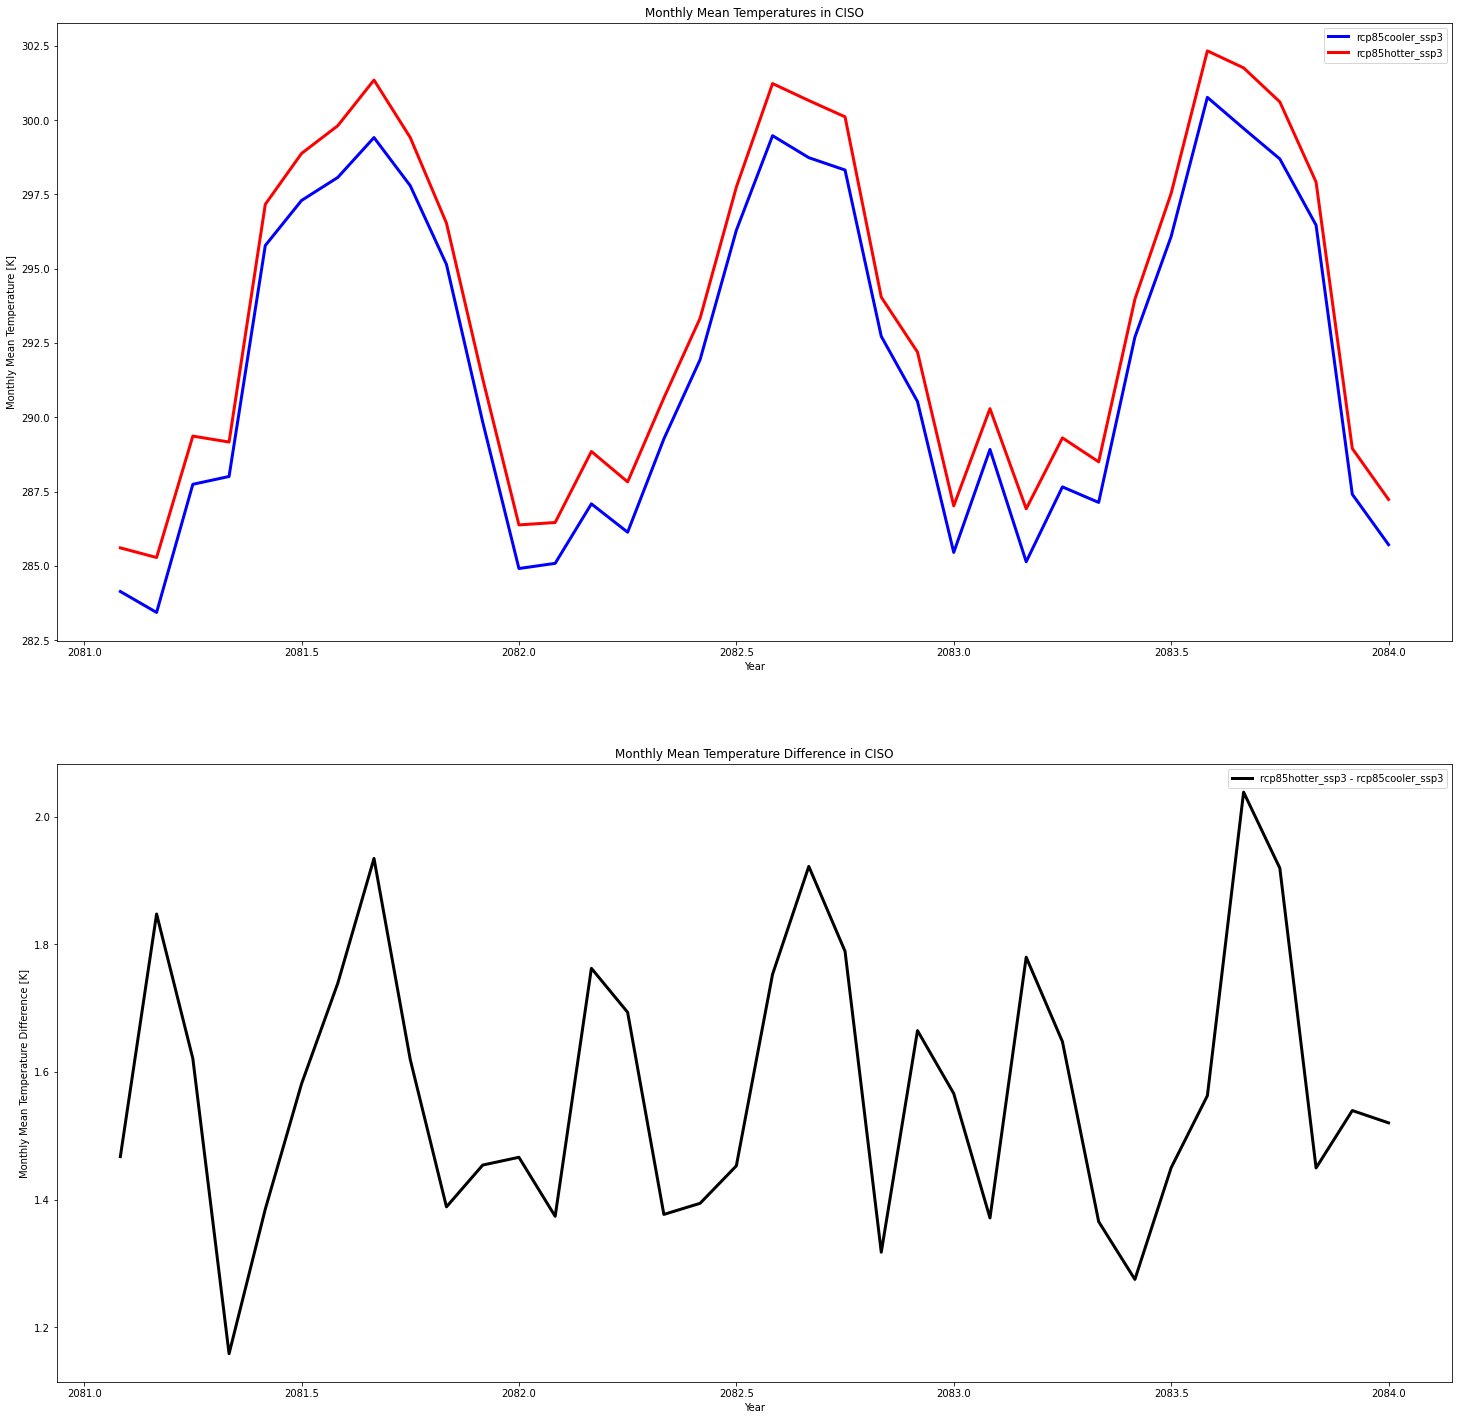

In [8]:
a = plot_monthly_data(ba_to_plot = ba_to_plot, 
                      monthly_df = monthly_df, 
                      image_output_dir = image_output_dir, 
                      save_images = True)
